In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
numpy = lambda x : x.detach().cpu().numpy().squeeze()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.__version__

import pyrtools as pt
import plenoptic as po

(2456, 816)


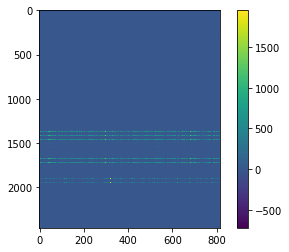

In [2]:
# here is a batch of texture statistics that have been computed offline on 800 texture images
# TODO move them to a handy place, so that they can be use by default in texture_statistics

X = np.load('metamer_PS_samples.npy')
print(X.shape)

# the texture statistics take interesting values
plt.imshow(X, aspect=.4)
plt.colorbar()

(-10, 10)

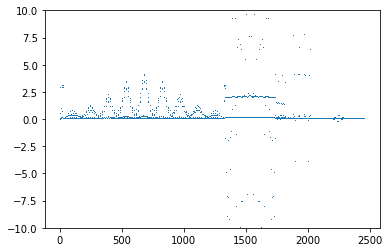

In [3]:
# TODO identify the coefficients that stay silent / go crazy

mu = X.mean(axis=1)
plt.plot(mu, ',');
plt.ylim((-10,10))

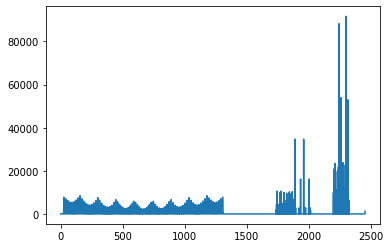

In [4]:
# As a first step, we divide each coefficient by its standard deviation:

# calculate the normalization factor
sigma = X.std(axis=1)
sigma[sigma<.00001] = 1
normalizationFactor = 1 / sigma

plt.plot(normalizationFactor);

normalizationFactor = torch.diag(torch.tensor(normalizationFactor, dtype=torch.float32))

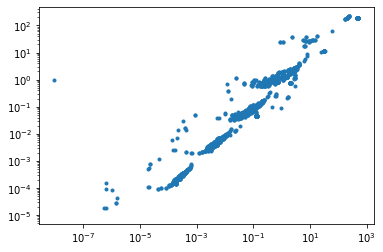

In [5]:
# plt.plot(mu, sigma, '.')

plt.loglog(mu, sigma, '.')

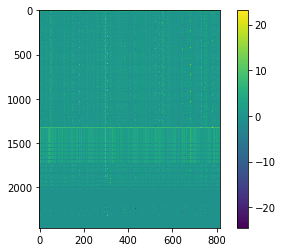

In [6]:
# much less crazy indeed
plt.imshow(normalizationFactor.numpy() @ X, aspect=.4)
plt.colorbar()

In [7]:
model = po.simul.Texture_Statistics([256,256], normalizationFactor = normalizationFactor)

In [8]:
image = plt.imread('../data/nuts.pgm').astype(float)/255.
im0 = torch.tensor(image, requires_grad=True, dtype = torch.float32).squeeze().unsqueeze(0).unsqueeze(0)
# clamp pixels between 0,1
c = po.RangeClamper([image.min(), image.max()])
M = po.synth.Metamer(im0, model)

In [9]:
# testing fraction removed

In [10]:
matched_image, matched_representation = M.synthesize(max_iter=300, learning_rate=1, seed=1, optimizer='SGD',
                                                     fraction_removed=.1, clamper = c)

100%|██████████| 300/300 [04:56<00:00,  1.01it/s, gradient_norm=2.6420e-01, learning_rate=0.0625, loss=2.1645e+00]


In [11]:
# just checking
M.optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0625
    momentum: 0.8
    nesterov: True
    weight_decay: 0
)

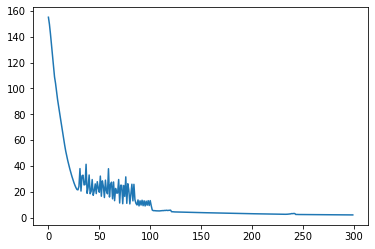

In [12]:
plt.plot(M.loss)

Difference statistics:
  Range: [0, 1]
  Mean: -0.002177,  Stdev (rmse): 0.495747,  SNR (dB): -2.752258

 model metric: 0.043574512004852295


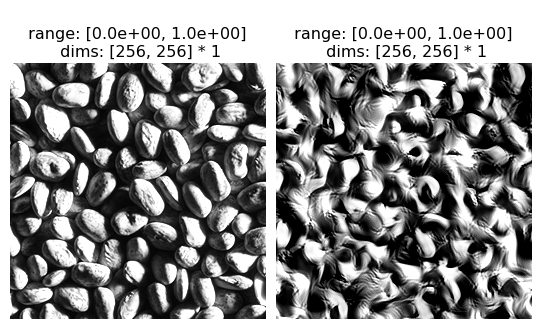

In [13]:
pt.imshow([image, numpy(M.matched_image)]);
pt.image_compare(image, numpy(M.matched_image))
m = po.metric.model_metric(M.target_image, M.matched_image, model).item()
print('\n model metric: ' + str(m))


In [19]:
# TODO
# more comparison of optimizers

# when synthesis method is ran several times
# store multiple samples of the generated textures in the object
# so that they can be plotted together and eyeball compared 

In [ ]:
# we could also consider a full decorrelation, and dimensionality reduction
# spoiler alert: this does not seem to be a great idea

evals, evecs = np.linalg.eigh(np.cov(X))
evals = evals[::-1]
evecs = evecs[:,::-1]

epsilon = 1e-10 # sic
k = np.where(evals > epsilon)[0].max()

plt.semilogy(evals)
plt.axhline(epsilon)
plt.axvline(k)
plt.show()

print(evals[:k].sum() / evals.sum())

# decorrelation and low dimensional projection
# S = np.diag(1 / np.sqrt(evals[:k])) @ evecs[:, :k].T
S = evecs[:, :k] @ np.diag(1 / np.sqrt(evals[:k])) @ evecs[:, :k].T
S = torch.tensor(S, dtype=torch.float32)
S.shape

In [ ]:
# superficially seems similar
plt.plot(np.diag(evecs[:, :k] @ np.diag(1 / np.sqrt(evals[:k])) @ evecs[:, :k].T))

In [ ]:
plt.imshow(numpy(S) @ X, aspect=.4)
plt.colorbar()

In [ ]:
model = po.simul.Texture_Statistics([256,256], normalizationFactor = S)

In [ ]:
image = plt.imread('../data/nuts.pgm').astype(float)/255.
im0 = torch.tensor(image, requires_grad=True, dtype = torch.float32).squeeze().unsqueeze(0).unsqueeze(0)
# clamp pixels between 0,1
c = po.RangeClamper([image.min(), image.max()])
M = po.synth.Metamer(im0, model)

In [ ]:
matched_image, matched_representation = M.synthesize(max_iter=300, learning_rate=1, seed=1, optimizer='SGD',
                                                     fraction_removed=.05, clamper = c)

In [ ]:
pt.imshow([image, numpy(M.matched_image)]);
pt.image_compare(image, numpy(M.matched_image))
m = po.metric.model_metric(M.target_image, M.matched_image, model).item()
print('\n model metric: ' + str(m))
